# Imports and Setup

In [1]:
from pathlib import Path
import torch
import torchvision
import altair
import seaborn
import tqdm
import ipywidgets
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.manifold import TSNE
import pandas as pd


In [2]:
content_path = '/notebooks'
data_path = './data/'
content_path = Path(content_path)

In [ ]:
def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'VAE/'):
    os.makedirs(content_path/'VAE/')

if not os.path.exists(data_path):
    os.makedirs(data_path)

# Set random seed
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

# VAE

### Define Hyperparameters

In [37]:
# Necessary Hyperparameters 
num_epochs = 50
learning_rate = 1e-3
batch_size = 128  # OR 100
latent_dim = 50 #25 # 50 #20             # Choose a value for the size of the latent space

# Additional Hyperparameters 
beta = 1.5


# (Optionally) Modify transformations on input
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])
])

# (Optionally) Modify the network's output for visualizing your images
def denorm(x):
    unnormalize = transforms.Normalize([-0.1307 / 0.3081], [1 / 0.3081])
    x = unnormalize(x)
    x = x.view(x.size(0), 1, 28, 28)

    return x

### Data loading


In [38]:
train_dat = datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
test_dat = datasets.MNIST(data_path, train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, content_path/'VAE/image_original.png')

In [39]:
# set random seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        
        # Define encoder network architecture
        self.encode_before_flatten = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.encode_after_flatten = nn.Sequential(
            nn.Linear(256, 128),   #24 * 15 * 15
            nn.ReLU(),
            nn.Linear(128, 64),   #24 * 15 * 15
            nn.ReLU()

        )

        self.encode_mu = nn.Sequential(
            nn.Linear(64, latent_dim),
            nn.ReLU()
        )

        self.encode_var = nn.Sequential(
            nn.Linear(64, latent_dim),
            nn.ReLU()
        )



        self.decode_z_first = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU()
        )

        self.decode_z_second = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size = 4, stride = 2, padding = 1)
        )

        
    def encode(self, x):
        # Approximate posterior inference
        x = self.encode_before_flatten(x)
        x = torch.flatten(x,1)
        x = self.encode_after_flatten(x)
        mu = self.encode_mu(x)
        logvar = self.encode_var(x)
        return mu, logvar

    def reparametrize(self, mu, logvar):
        epsilon = torch.randn_like(mu)
        std = torch.exp(logvar/2)
        z = mu + std * epsilon
        return z


    def decode(self, z):
        # Reconstructing data
        x_hat = self.decode_z_first(z)
        x_hat = x_hat.view(-1, 256, 1, 1) # reshape to 256 channels, 1x1 'image'
        x_hat = self.decode_z_second(x_hat)
        return x_hat

    
    def forward(self, x):
        # Encode x
        mu, logvar = self.encode(x)
        # Reparametrize
        z = self.reparametrize(mu,logvar)
        # Decode (reconstructing x)
        x_hat = self.decode(z)

        return mu, logvar, x_hat


model = VAE(latent_dim).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 1434245
VAE(
  (encode_before_flatten): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encode_after_flatten): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=Tru

## Training

**VAE Loss Explanation**

We use the Beta VAE loss
$$\mathcal{L}(\phi, \theta, \beta) = \mathbb{E}_{p_{data}(x)}[E_{q_{\phi}(z\mid x)}[\log p_{\theta}(x\mid z)] - \beta KL[q_{\theta}(z\mid x)\mid\mid p(z)]]$$

We assume that the VAE prior $p(z)$ and likelihood $p_{\theta}(x \mid z)$ is a Gaussian distribution such that $p(z) = \mathcal{N}(z; 0, I)$ and $p_{\theta}(x \mid z = \mathcal{N}(x;G_{\theta}(z),\sigma^2I)$ as we take the output domain to contain a continuous range of values. Also, in a VAE we define $q_{\phi}(z\mid x) = \mathcal{N}(z; \mu_{\phi}(x), diag(\sigma^2+{\phi}(x)))$ with $\mu_{\phi}, \log\sigma_{phi}(x) = NN_{\phi}(x)$. Now, note that $p(z)$ and $q_{\phi}(z\mid x)$ are factorized (i.e. $p(z) = \prod_{i = 1}^d p(z_i)$ and $q(z) = \prod_{i = 1}^d q(z_i \mid x))$, so that $p(z)$ and $q_{\phi}(z\mid x)$ are both factorized Gaussian distributions. Hence as shown in the lecture notes (eq. 14-16) we have a closed form solution for the KL divergence:

$$KL[q_{\phi}(z\mid x)\mid\mid p(z)] = \frac{1}{2}(||\mu_{\phi}(x)||^2_2 + ||\sigma_{\phi}(x)||^2_2 - 2\langle\log\sigma_{\phi}(x),1\rangle - d)$$

Recall the reparametrization trick in which we have $p(\epsilon) := \mathcal{N}(\epsilon;0,I)$ and $T_\phi(x,\epsilon) := \mu_{\phi} + \sigma_{\phi} \odot \epsilon$ so that
$$\mathbb{E}_{q_{\phi}(x\mid z)}[\log p_{\theta}(x\mid z)] = \mathbb{E}_{p(\epsilon)}[\log p_{\theta}(x\mid T_{\phi}(x,\epsilon))]$$

Hence, by the Gaussian likelihood assumption and the use of the reparametrization trick,
$$\mathbb{E}_{q_{\phi}(x\mid z)}[\log p_{\theta}(x\mid z)] = E_{p(\epsilon)}[-\frac{1}{2\sigma^2}||x - G_{\theta}(T_{\phi}(x,\epsilon))||^2_2] + \text{const.}$$

Finally, we can find a Monte Carlo estimation of the loss function:
$$\mathcal{L}(\phi, \theta, \beta) = \frac{1}{M}\sum_{m = 1}^M\log p_{\theta}(x_m\mid T_{\phi}(x_m,\epsilon_m)) - KL[q_{\phi}(z_m\mid x_m)\mid\mid p(z_m)]$$
where $x_1,...,x_m \sim \{x_n\}^M, \epsilon_1,...,\epsilon_M \sim \mathcal{N}(0,I)$.

Combining the closed form of the KL divergence, the simplified form of the reconstruction error, and the monte carlo estimate of the loss, the loss function has the form
$$\mathcal{L}(\phi, \theta, \beta) = \frac{1}{M}\sum_{m = 1}^M [-\frac{1}{2\sigma_m^2}||x - G_{\theta}(T_{\phi}(x_m,\epsilon_m))||^2_2 - \beta(\frac{1}{2}(||\mu_{\phi}(x_m)||^2_2 + ||\sigma_{\phi}(x_m)||^2_2 - 2\langle\log\sigma_{\phi}(x_m),1\rangle - d)]$$

and
$$\text{Reconstruction Loss} = \frac{1}{M}\sum_{m = 1}^M -\frac{1}{2\sigma^2}||x - G_{\theta}(T_{\phi}(x_m,\epsilon_m))||^2_2$$

$$\text{KL Regularizer} = \frac{1}{M}\sum_{m = 1}^M (\frac{1}{2}(||\mu_{\phi}(x_m)||^2_2 + ||\sigma_{\phi}(x_m)||^2_2 - 2\langle\log\sigma_{\phi}(x_m),1\rangle - d)$$

In order to maximize this loss function (which is the objective of the VAE), we minimize the negation, giving the objective
$$\phi^*, \theta^* = argmin \frac{1}{M}\sum_{m = 1}^M \text{KL Regularizer} - \text{Reconstruction Loss}$$

Also note that this loss is computed pixelwise over the input and output images. 


The role of the reconstruction loss is to measure how well the model reconstructs images from the data distribution. On the other hand, the encoder $q_{\phi}(z\mid x)$ maps our image data $x$ into $z$ in the latent space and so by aiming to minimize the KL divergence between $p(z)$ and $q_{\phi}(z\mid x)$ we aim to draw $q_{\phi}(z\mid x)$ to $p(z)$. This means that we want to try to move the encoded values toward being normally distributed. This leads to a more disentangled representation and hence permits better sampling from the latent space.

In [40]:
# Collect losses
train_losses = []
train_reconstruction_loglike_losses = []
train_KL_losses = []

test_losses = []
test_reconstruction_loglike_losses = []
test_KL_losses = []

def reconstruction_loss_fn(recon_x, x):
    sigma_sq = 1    # Sigma of the distribution p(x|z)
    loss = nn.MSELoss(reduction='sum')
    reconstruction_loss = -.5*loss(recon_x,x)
    return reconstruction_loss

def kl_regularizer_fn(mu, logvar):
    std = torch.exp(logvar)**.5
    kl_regularizer = .5 * torch.sum(torch.square(mu) + torch.exp(logvar) - 2 * torch.log(std) - 1)
    return kl_regularizer

def loss_function_VAE(recon_x, x, mu, logvar, beta):

        reconstruction_loss = reconstruction_loss_fn(recon_x, x)
        kl_regularizer = kl_regularizer_fn(mu, logvar)

        values = reconstruction_loss - beta * kl_regularizer
        loss = - (1 / batch_size) * values  # negate total loss because minimizing, not maximizing

        return loss

model.train()
for epoch in range(num_epochs): 
    train_loss = 0
    train_reconstruction_loss = 0
    train_kl_regularizer = 0
    # <- You may wish to add logging info here
    with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
        for batch_idx, (data, _) in enumerate(tepoch):   
            data = (data,_)[0] # Need at least one batch/random data with right shape -
            data = data.to(device=device)  

            mu, logvar, recon_x = model(data)
            loss = loss_function_VAE(recon_x, data, mu, logvar, beta)

            reconstruction_loss = (1/len(data)) * reconstruction_loss_fn(recon_x, data)
            kl_regularizer = (1/len(data)) * kl_regularizer_fn(mu, logvar)

            train_loss = train_loss + loss.item()
            train_reconstruction_loss = train_reconstruction_loss + reconstruction_loss.cpu().detach()
            train_kl_regularizer = train_kl_regularizer + kl_regularizer.cpu().detach()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(loss=loss.item()/len(data))
    
    # Append training losses at the end of the epoch
    train_losses.append(train_loss / len(loader_train))
    train_reconstruction_loglike_losses.append(train_reconstruction_loss / len(loader_train))
    train_KL_losses.append(train_kl_regularizer / len(loader_train))

    # Test losses
    test_loss = 0
    test_reconstruction_loss = 0
    test_kl_regularizer = 0

    with torch.no_grad():
        for test_data in loader_test:
            test_data = test_data[0]
            test_data = test_data.to(device=device)

            test_mu, test_logvar, test_recon_x = model(test_data)

            test_loss_add = loss_function_VAE(recon_x, data, mu, logvar, beta)
            test_reconstruction_loss_add = (1/len(test_data)) * reconstruction_loss_fn(test_recon_x, test_data)
            test_kl_regularizer_add = (1/len(test_data)) * kl_regularizer_fn(test_mu, test_logvar)

            test_loss = test_loss + test_loss_add.item()
            test_reconstruction_loss = test_reconstruction_loss + test_reconstruction_loss_add.cpu().detach()
            test_kl_regularizer = test_kl_regularizer + test_kl_regularizer_add.cpu().detach()

                
    test_losses.append(test_loss / len(loader_test))
    test_reconstruction_loglike_losses.append(test_reconstruction_loss / len(loader_test))
    test_KL_losses.append(test_kl_regularizer / len(loader_test))

    # Save model
    if epoch == num_epochs - 1:
        with torch.no_grad():
            torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                content_path/'VAE/VAE_model.pth')


Epoch 49: 100%|██████████| 469/469 [00:22<00:00, 20.85batch/s, loss=1.12]


Text(0.5, 0.98, 'KL Loss')

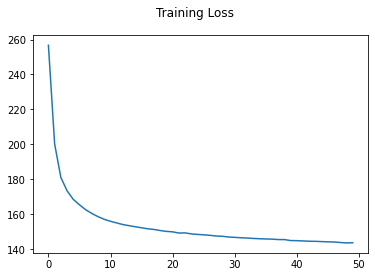

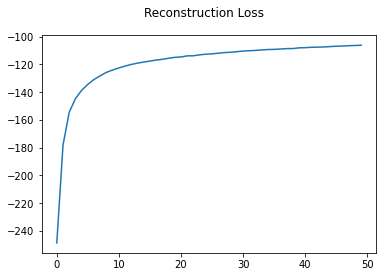

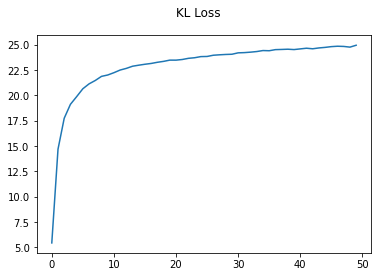

In [41]:
# Loss for Training
plt.figure()
plt.plot(train_losses)
plt.suptitle('Training Loss')

plt.figure()
plt.plot(train_reconstruction_loglike_losses)
plt.suptitle("Reconstruction Loss")

plt.figure()
plt.plot(train_KL_losses)
plt.suptitle("KL Loss")


Text(0.5, 0.98, 'Test KL Loss')

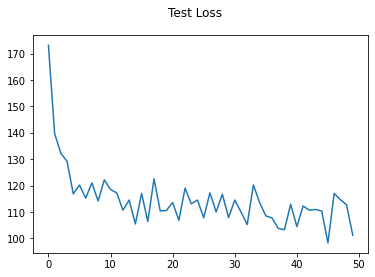

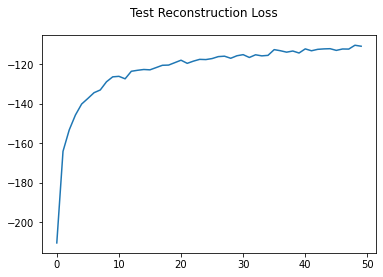

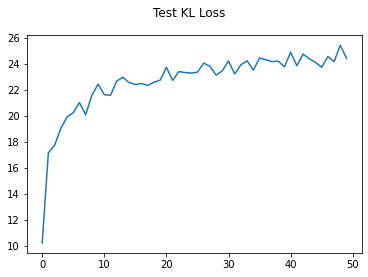

In [42]:
# Loss for Test
plt.figure()
plt.plot(test_losses)
plt.suptitle('Test Loss')

plt.figure()
plt.plot(test_reconstruction_loglike_losses)
plt.suptitle('Test Reconstruction Loss')

plt.figure()
plt.plot(test_KL_losses)
plt.suptitle('Test KL Loss')

## Visualizations


### Visualization of Reconstructed and Generated Images

/opt/conda/lib/python3.8/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input images
--------------------------------------------------
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------


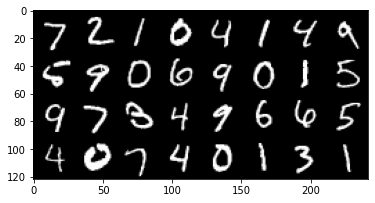

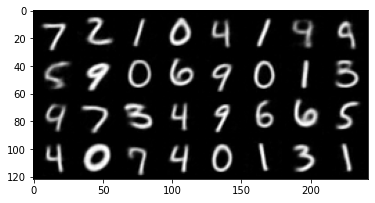

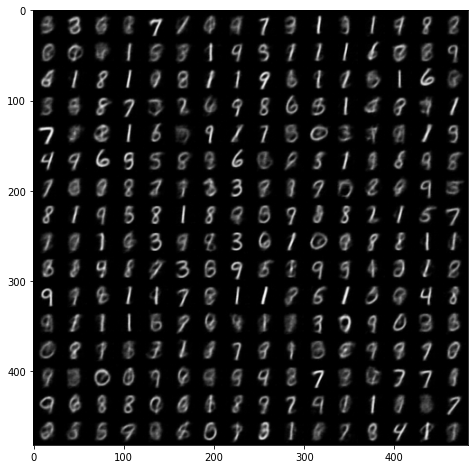

In [55]:
# Load the model
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]

# Visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

# Visualize the reconstructed images of the last batch of test set
print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    fixed_input = fixed_input.to(device=device)
    recon_batch = model(fixed_input)[2] # third item is the reconstruction
    
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

# Visualize generated images
print('Generated Images')  
print('-'*50)
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    z = z.to(device=device)
    samples = model.decode(z) 
    
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)

### T-SNE on Embeddings

In [44]:
test_dataloader = DataLoader(test_dat, 10000, shuffle=False)

z_embedded = []
with torch.no_grad():
    for test_data in loader_test:
        test_data = test_data[0]
        test_data = test_data.to(device=device)
        
        mu, logvar = model.encode(test_data)
        z = model.reparametrize(mu, logvar)
        z_embedded.append(z)

z_embedded = torch.cat(z_embedded).cpu().detach()
tsne = TSNE(n_components=2) 
tsne_results = tsne.fit_transform(z_embedded)

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

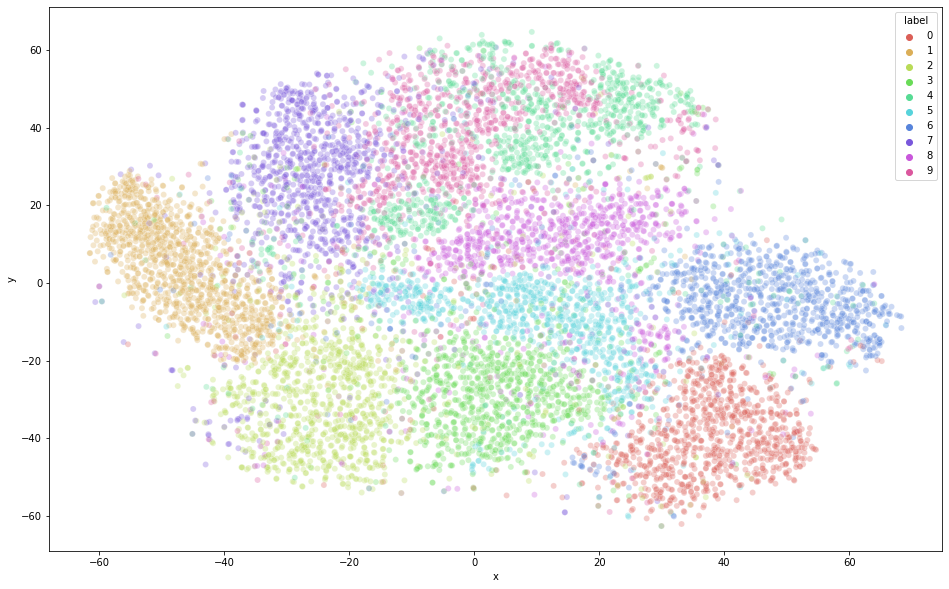

In [46]:
# Visualization of the latent space using TSNE
images, labels = zip(*[(x[0].numpy()[0,:,:,None], x[1]) for x in test_dataloader.dataset])

num_points = min(10001, len(labels))
data = pd.DataFrame({'x':tsne_results[:, 0], 'y':tsne_results[:, 1], 'label':labels,
                    'image': images})
data = data.sample(n=num_points, replace=False)


plt.figure(figsize=(16,10))
sns.scatterplot(
    x='x' , y='y',
    hue='label',
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.3
)

### Interpolation in the Latent Space


In [ ]:
first_digit = 9
second_digit = 5

coeffs = [0, .2 ,.3 , .4, .5, .6, .7, .8, .9, 1]

def interpolate(dataloader):
    for im_test, num_test in dataloader:
        first_im = im_test[num_test == first_digit][0].reshape(1,1,28,28)
        second_im = im_test[num_test == second_digit][0].reshape(1,1,28,28)

        mu_first, logvar_first, recon_first = model(first_im.cuda())
        enc_first_im = model.reparametrize(mu_first, logvar_first).cuda()

        mu_second, logvar_second, recon_second = model(second_im.cuda())
        enc_second_im = model.reparametrize(mu_second, logvar_second).cuda()

        transition = torch.Tensor(10, 1, 28, 28)
        for i in range(len(coeffs)):
            coeff = coeffs[i]
            new = enc_first_im + coeff * (enc_second_im - enc_first_im)
            new = model.decode(new)
            transition[i] = new

        transitions = make_grid(transition, nrow=10, padding=2, normalize=False,
                                range=None, scale_each=False, pad_value=0)
        plt.figure(figsize = (8,8))
        show(transitions)   


loader_test_new = DataLoader(test_dat, len(test_dat), shuffle=False)
interpolate(loader_test_new)